# Question Generator - Experimento

Utiliza um transformer T5 pré treinado em português e disponibilizado pelo [huggingfaces](https://platiagro.github.io/tutorials/).<br>
### **Em caso de dúvidas, consulte os [tutoriais da PlatIAgro](https://platiagro.github.io/tutorials/).**

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [3]:
dataset = "/tmp/data/reports_contexts_small.csv" #@param {type:"string"}

### Dados para Treinamento

# Dataset
column_context = "context" #@param ["context"] {type:"string",label:"Coluna contexto",description:"Coluna em que estão contidas os contextos"}
column_question = "questions" #@param {type:"string",label:"Coluna pergunta",description:"Coluna em que estão contidas listas de perguntas por células. Apenas considerada se train_from_zero=True"}
train_from_zero = False #@param {type:"boolean",label:"Treinamento do algorítimo do zero",description:"Caso True utiliza o algorítimo com finne-tunning no squad em português. Caso True retreina do zero"}
train_from_squad = False #@param {type:"boolean",label:"Treinamento do algorítimo pelo Squad",description:"Caso True utiliza treinará algorítimo com finne-tunning no squad em português. Caso False teinará com o dataset passado"}
expand_context = True #@param {type:"boolean",label:"Expansão de contextos",description:"Expande o contexto passado com as perguntas geradas separadas por espaço"}

#prepare_data
dev_size_from_data= 0.2 #@param {type:"float",label:"Porcentagem para avaliação",description:"Parcela dos dados utilizadas para avaliação, sendo o restante utilizado para treino. Apenas considerada se train_from_zero=True e train_from_squad=True"}
test_size_from_dev= 0.5 #@param {type:"float",label:"Porcentagem para teste",description:"Parcela dos dados utilizadas para avaliação que serã utilizados para teste, sendo o restante utilizado para validação. Apenas considerada se train_from_zero=True"}
#batch_dataset_preparation = 30 #@param {type:"float",label:"Batch para preparação dos dados",description:"Tamanho do batchque o tokenizador utilizará para preparar o dataset. Apenas considerada se train_from_zero=True"}

model_name = "unicamp-dl/ptt5-base-portuguese-vocab" #@param {type:"string",label:"Modelo",description:"Modelo utilizado da base de modelo do hugginfaces"}
PREFIX = "gerador_perguntas:" #@param {type:"string",label:"Prefixo para o T5",description:"Incluindo em cada sentença passada ao transformers. Apenas considerado se train_from_zero=True"}
num_gen_sentences = 2 #@param {type:"integer",label:"Número de perguntas geradas experimentação",description:"Apenas consideradao se train_from_zero=True"}
infer_num_gen_sentences = 10 #@param {type:"integer",label:"Número de perguntas geradas na inferência"}
train_batch_size= 2 #@param {type:"integer",label:"Batch size para treino",description:"Tamanho do batch de treino. Está associado a num_gen_sentences. Apenas considerado se train_from_zero=True"}
eval_batch_size= 8 #@param {type:"integer",label:"Batch size para avaliação",description:"Tamanho do batch de validação e teste. Está associado a num_gen_sentences. Apenas considerado se train_from_zero=True"}
infer_batch_size = 8  #@param {type:"integer",label:"Batch size para inferência"}
no_repeat_ngram_size= 2 #@param {type:"float",label:"Sequência máxima de tokens repetidos",description:"Após a repetição de tokens configurada, força a trocar de token na geração do decoder"}
temperature= 0.7 #@param {type:"float",label:"Temperatura de randomização do decoder",description:"Pode ser entre 0 e 1. Quanto mais próxima de 0, mais próximo da decodificação gulosa (que procura tokens de maior probabilidade), quanto mais próximo de 1 randomiza entre os tokens contidos no top_p"}
top_p= 0.92 #@param {type:"float",label:"Porcentagem de consideração",description:"Considera apenas os tokens que compoẽ a porcentagem top_op no histograma de probabilidades dos tokens de saída https://huggingface.co/blog/how-to-generate"}
source_max_length= 512 #@param {type:"integer",label:"Tamanho do contexto de entrada",description:"Tamanho máximo contexto de entrada em tokens"}
target_max_length= 100 #@param {type:"integer",label:"Tamanho da sentença gerada",description:"Tamanho máximo da pergunta derada em tokens"}
learning_rate= 3.0e-5 #@param {type:"float",label:"Taxa de aprendizado"}
eps= 1.0e-08 #@param {type:"integer",float:"Valor de estabilidade do otimizador Adam"}
seed = 13 #@param {type:"integer",label:"Semente de aleatoriedade"}

#lightning_params
num_gpus= 1 #@param {type:"integer",label:"Numero de GPUs"}
profiler= True #@param {type:"integer",label:"Resumo"}
max_epochs= 1 #@param {type:"integer",label:"Máximo de épocas para treinamento"}
accumulate_grad_batches= 16 #@param {type:"integer",label:"Batchs acumulados",description:"Batchs acumulados antes de atualizar os pesos"}
check_val_every_n_epoch= 1 #@param {type:"integer",label:"Frequência Validação",description:"Frequência da chamada da validação em épocas"}
progress_bar_refresh_rate= 1 #@param {type:"integer",label:"Frequência de autuazaliação da barra de progresso"}
gradient_clip_val= 1.0 #@param {type:"float",label:"Favor de corte dos gradientes","description":"O fator evita que os gradientes explodam definindo um limite para os mesmos"}
fast_dev_run= False #@param {type:"boolean",label:"Rodar um batch",description:"Utilizado para validar que todas as partes estão funcionando antes de treinar o modelo por inteiro"}

#early_stop_callback
monitor= 'avg_train_loss' #@param {type:"integer",label:"Frequência de autuazaliação da barra de progresso"}
min_delta= 0.01 #@param {type:"integer",label:"Variação mínima entre épocas"}
patience= 1 #@param {type:"integer",label:"Epera após atingir variação mínima"}
verbose= False #@param {type:"boolean",label:"Disponibilizar informações early stop"}
mode= 'min' #@param ["min","max"] {type:"integer",label:"Modo de parada",description: "Modo de funcionamento para critério de parada"}

## Leitura do conjunto de dados

O exemplo abaixo faz a leitura de dados tabulares (ex: .csv).<br>
Modifique o código de acordo com o tipo de dado que desejar ler.

In [4]:
import pandas as pd

df = pd.read_csv(dataset)

In [5]:
if "context" not in df.columns:
    raise ValueError("A coluna context deve estar obrigatoramente contida no dataset")

## Download de arquivos necessários

In [6]:
import os
GLOVE_WEIGHTS_PATH = "glove_s300_portugues.txt"
SQUAD_TRAIN_PATH = "squad-train-v1.1.json"
SQUAD_DEV_PATH = "squad-dev-v1.1.json"
if not os.path.exists(GLOVE_WEIGHTS_PATH):
    !wget -nc https://storage.googleapis.com/platiagro/Vident/glove_s300_portugues.txt
if not os.path.exists(SQUAD_TRAIN_PATH):
    !wget -nc https://storage.googleapis.com/platiagro/Vident/squad-train-v1.1.json
if not os.path.exists(SQUAD_DEV_PATH):
    !wget -nc https://storage.googleapis.com/platiagro/Vident/squad-dev-v1.1.json

## Divide dataset em subconjuntos de treino, validação e teste

Subconjunto de treino: amostra de dados usada para treinar o modelo.<br>
Subconjunto de treino: amostra de dados usada para validar o modelo.<br>
Subconjunto de teste: amostra de dados usada para fornecer uma avaliação imparcial do treinamento do modelo no subconjunto de dados de treino.

In [7]:
from sklearn.model_selection import train_test_split
    
if (train_from_zero and not train_from_squad):
    df_train,df_ = train_test_split(df, train_size=dev_size_from_data)
    df_valid, df_test = train_test_split(df_, train_size=test_size_from_dev)
    train_output = 'df_squad_train_bert_chuncked.csv'
    valid_output = 'df_squad_valid_bert_chuncked.csv'
    test_output =  'df_squad_test_bert_chuncked.csv'
    df_train.to_csv(os.path.join(train_output),index=False)
    df_valid.to_csv(os.path.join(valid_output),index=False)
    df_test.to_csv(os.path.join(test_output),index=False)
else:
    df_test = df

## Configurando Argumentos

In [8]:
# Mapeando dirpaths
data_dir  =  root_dir = os.getcwd()
logs_dir = os.path.join(root_dir)
# Colocando parâmetros de entrada no fromato esperado
hparams = {
    "model_name":model_name,
    "PREFIX":PREFIX,
    "num_gen_sentences":num_gen_sentences,
    "infer_num_gen_sentences":infer_num_gen_sentences,
    "no_repeat_ngram_size":no_repeat_ngram_size,
    "temperature":temperature,
    "top_p":top_p,
    "train_batch_size":train_batch_size,
    "eval_batch_size":eval_batch_size,
    "infer_batch_size":infer_batch_size,
    "source_max_length":source_max_length,
    "target_max_length":target_max_length,
    "learning_rate":learning_rate,
    "eps":eps,
    "seed":seed,
}

lightning_params = {
    "num_gpus":num_gpus,
    "profiler":profiler,
    "max_epochs":max_epochs,
    "accumulate_grad_batches":accumulate_grad_batches,
    "check_val_every_n_epoch":check_val_every_n_epoch,
    "progress_bar_refresh_rate":progress_bar_refresh_rate,
    "gradient_clip_val":gradient_clip_val,
    "fast_dev_run":fast_dev_run,
}

early_stop_callback_params = {
     "monitor":monitor,
    "min_delta":min_delta,
    "patience":patience,
    "verbose":verbose,
    "mode":mode,    
}

prepare_data_params = {
     #"batch_dataset_preparation":batch_dataset_preparation,
     "test_size_from_dev":test_size_from_dev,
}

# Configurações
config = {'params':{'hparams':hparams,
                    'lightning_params':lightning_params,
                    'early_stop_callback_params':early_stop_callback_params,
                    'prepare_data_params':prepare_data_params },

        'dirpaths':{'data_dirpath':data_dir,
                'log_dirpath':logs_dir,
                'cwd_dirpath':root_dir},
}

## Treinamento do Zero / Recuperação dos pesos

In [9]:
import os
import pytorch_lightning as pl
from caller import Qgenerator_caller

# Criando Caller
qgenerator_caller = Qgenerator_caller(config)

#Fazendo Build
qgenerator_caller.build()


if train_from_zero:
        
    #Preparando dados
    if train_from_squad:
        squad_train_path = os.path.join(data_dir,'squad-train-v1.1.json')
        squad_dev_path= os.path.join(data_dir,'squad-dev-v1.1.json')
        
        prepared_datapaths = qgenerator_caller.prepare_data(squad_train_path=squad_train_path,
                                                        squad_dev_path=squad_dev_path)
    else:
        
        prepared_datapaths = {
                                'prepared_data_train_path':train_output,
                                 'prepared_data_valid_path':valid_output,
                                 'prepared_data_test_path':test_output
                             }
    
    
    # Treinamento
    qgenerator_caller.train(train_path=prepared_datapaths['prepared_data_train_path'],
                                valid_path=prepared_datapaths['prepared_data_valid_path'],
                                test_path=prepared_datapaths['prepared_data_test_path'],
                                glove_weights_path=GLOVE_WEIGHTS_PATH)

    MODEL_PATH = "trained_model.ckpt"
    qgenerator_caller.save_checkpoint(MODEL_PATH)
    
    # Avaliação
    qgenerator_caller.evaluate()
    #del qgenerator_caller
else:
    MODEL_PATH = "default_qgenerator_squad_pt.ckpt"
    if not os.path.exists(MODEL_PATH):
        !wget -nc https://storage.googleapis.com/platiagro/Vident/default_qgenerator_squad_pt.ckpt
    # Load do modelo
    qgenerator_caller.load_model(checkpoint_path=MODEL_PATH)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Downloading:   0%|          | 0.00/756k [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Global seed set to 13


Downloading:   0%|          | 0.00/456 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

## Gerando as perguntas

In [10]:
from aux_functions import build_df_result
contexts = df_test[column_context].to_numpy()
gen_questions_dict = qgenerator_caller.forward(contexts=contexts, num_gen_sentences=infer_num_gen_sentences)
df_result = build_df_result(gen_questions_dict,column_context=column_context,column_question=column_question)

100%|██████████| 2/2 [00:20<00:00, 10.27s/it]


## Expandindo os contextos

In [11]:
from expander import DocExpander

if expand_context:
    exp = DocExpander() 
    df_final = exp.expand_sql(df_result,context_column_name=column_context,questions_column_name = column_question)
else:
    df_final = df_result.copy()

## Salvando os resultados

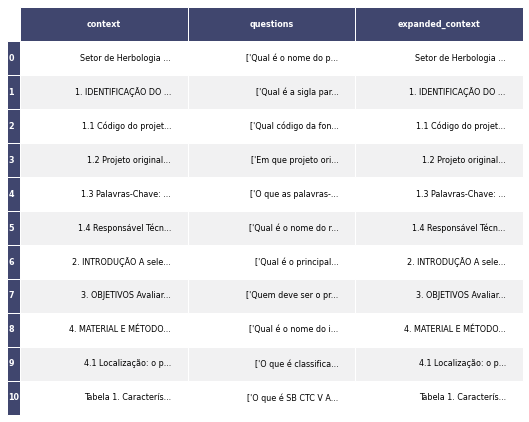

In [13]:
import matplotlib.pyplot as plt
from platiagro.plotting import plot_data_table
ax = plot_data_table(df_final)
plt.show()

In [11]:
df_final.to_csv(dataset, index=False)

## Salva resultados da tarefa

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.<br>
Use essa pasta para salvar modelos, metadados e outros resultados.

In [14]:
from joblib import dump

artifacts = {
    "model":qgenerator_caller,
    "expand_context":expand_context,
    "infer_num_gen_sentences":infer_num_gen_sentences,
    "column_context":column_context,
    "column_question":column_question
}    

dump(artifacts, "/tmp/data/qgenerator.joblib")

['/tmp/data/qgenerator.joblib']

## Liberando Memória da GPU

In [15]:
import torch
qgenerator_caller.free_memory()
del qgenerator_caller
torch.cuda.empty_cache() 